<a href="https://colab.research.google.com/github/datasistah/ml_system_design_class_notebooks/blob/main/20230602_Basics_of_LLMs._Expanded_Notebookipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install sentence_transformers

In [3]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-mpnet-base-v2')

In [4]:
sentences = [
    "it caught him off guard that space smelled of seared steak",
    "she could not decide between painting her teeth or brushing her nails",
    "he thought there'd be sufficient time is he hid his watch",
    "the bees decided to have a mutiny against their queen",
    "the sign said there was road work ahead so she decided to speed up",
    "on a scale of one to ten, what's your favorite flavor of color?",
    "flying stinging insects rebelled in opposition to the matriarch"
]

In [5]:
embeddings = model.encode(sentences)
embeddings.shape

(7, 768)

In [6]:
embeddings[0,:2] #row 1, first 2 columns

array([0.07613579, 0.03554152], dtype=float32)

In [7]:
from sentence_transformers.util import cos_sim

scores = cos_sim(embeddings[-1], embeddings[:-1]) #cosine similarity between the last sentence versus all the rest of the sentences

print(sentences[-1]) #print last sentence
for i, score in enumerate(scores[0]):
    print(f"{round(score.item(), 4)} | {sentences[i]}")

flying stinging insects rebelled in opposition to the matriarch
0.1232 | it caught him off guard that space smelled of seared steak
0.1967 | she could not decide between painting her teeth or brushing her nails
0.0523 | he thought there'd be sufficient time is he hid his watch
0.6084 | the bees decided to have a mutiny against their queen
0.1011 | the sign said there was road work ahead so she decided to speed up
-0.0492 | on a scale of one to ten, what's your favorite flavor of color?


In [10]:
scores = cos_sim(embeddings[-1], embeddings[:])


In [11]:
scores

tensor([[ 0.1232,  0.1967,  0.0523,  0.6084,  0.1011, -0.0492,  1.0000]])

#Question Answer


*   import question encoder and question tokenizer
*   import context encoder and context encoder tokenizer


Answer questions and prints answers that are located in the context list


In [12]:
from transformers import DPRContextEncoder, DPRContextEncoderTokenizer, DPRQuestionEncoder, DPRQuestionEncoderTokenizer
ctx_model = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')
ctx_tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')

question_model = DPRQuestionEncoder.from_pretrained('facebook/dpr-question_encoder-single-nq-base')
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained('facebook/dpr-question_encoder-single-nq-base')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.


In [24]:
questions = [
    "what is the capital city of australia?",
    "what is the best selling sci-fi book?",
    "how many searches are performed on Google?"
]

contexts = [
    "canberra is the capital city of australia",
    "what is the capital city of australia?",
    "the capital city of france is paris",
    "what is the best selling sci-fi book?",
    "sc-fi is a popular book genre read by millions",
    "the best-selling sci-fi book is dune",
    "Google serves more than 2 trillion queries annually",
    "Google is a popular search engine"
]

In [25]:
xb_tokens = ctx_tokenizer(contexts, max_length=256, padding='max_length',
                          truncation=True, return_tensors='pt')
xb = ctx_model(**xb_tokens)

xq_tokens = question_tokenizer(questions, max_length=256, padding='max_length',
                               truncation=True, return_tensors='pt')
xq = question_model(**xq_tokens)

In [26]:
#xb = contexts values
# xq = questions

In [27]:
xb.pooler_output.shape, xq.pooler_output.shape

(torch.Size([8, 768]), torch.Size([3, 768]))

In [28]:
xq.pooler_output

tensor([[ 0.0719, -0.0714,  0.1439,  ..., -0.0902,  0.1760,  0.0611],
        [ 0.1001, -0.2028,  0.0938,  ...,  0.2077,  0.2748,  0.0466],
        [ 0.2906,  0.1550,  0.4263,  ...,  0.0992,  0.2863,  0.2181]],
       grad_fn=<SliceBackward0>)

In [29]:
import torch

for i, xq_vec in enumerate(xq.pooler_output):
    probs = cos_sim(xq_vec, xb.pooler_output)
    argmax = torch.argmax(probs)
    print(questions[i])
    print(contexts[argmax])
    print('---')

what is the capital city of australia?
canberra is the capital city of australia
---
what is the best selling sci-fi book?
the best-selling sci-fi book is dune
---
how many searches are performed on Google?
Google serves more than 2 trillion queries annually
---


#Image-Text Embedding

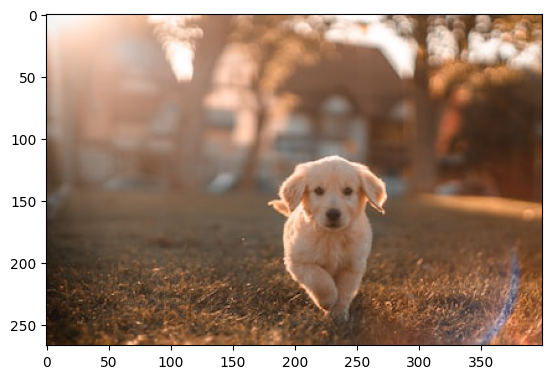

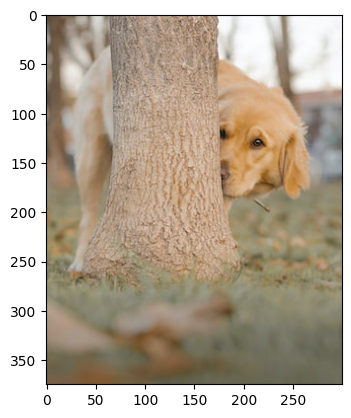

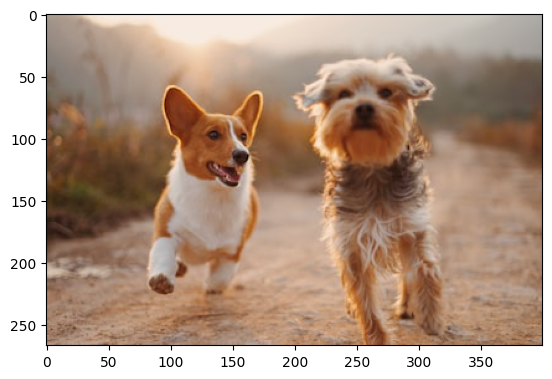

In [30]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import requests

urls = [
    "https://images.unsplash.com/photo-1576201836106-db1758fd1c97?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=400&q=80",
    "https://images.unsplash.com/photo-1591294100785-81d39c061468?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=300&q=80",
    "https://images.unsplash.com/photo-1548199973-03cce0bbc87b?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=400&q=80"
]

images = [
    Image.open(requests.get(url, stream=True).raw) for url in urls]

# let's see what we have
for image in images:
    plt.show(plt.imshow(np.asarray(image)))

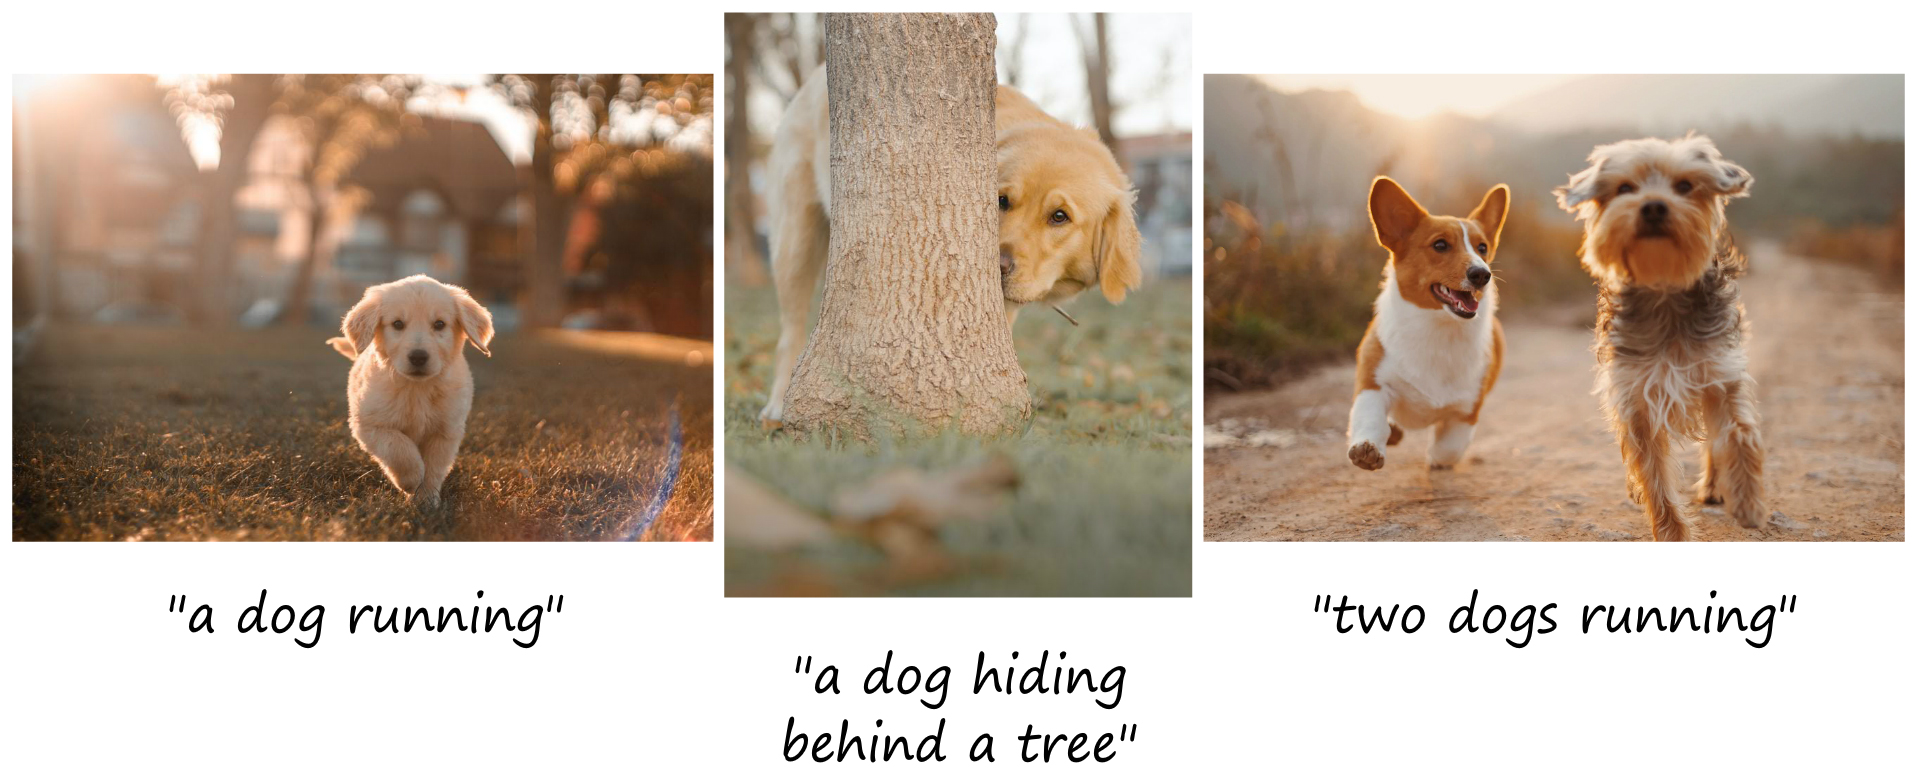

In [31]:
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')

In [32]:
 captions = ["a dog hiding behind a tree",
            "two dogs running",
            "a dog running",
            "a cucumber on a tree",
            "trees in the park",
            "a cucumber dog"]

inputs = processor(
    text=captions, images=images,
    return_tensors='pt', padding=True
)

outputs = model(**inputs)

probs = outputs.logits_per_image.argmax(dim=1)
probs

tensor([2, 0, 1])

a dog running


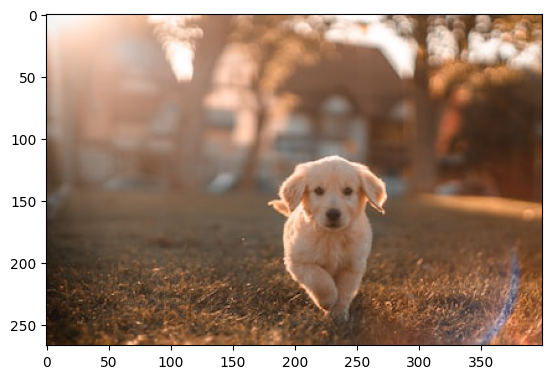

a dog hiding behind a tree


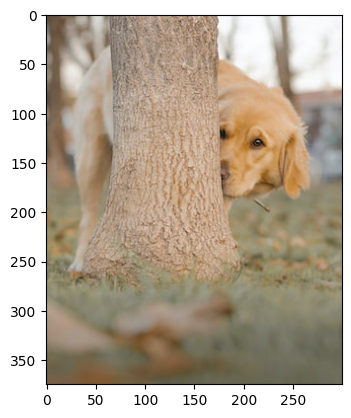

two dogs running


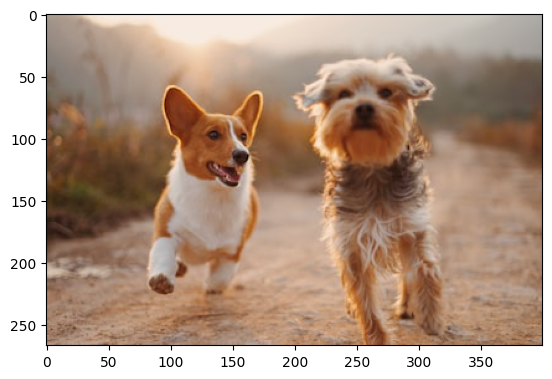

In [33]:
for i, image in enumerate(images):
    argmax = probs[i].item()
    print(captions[argmax])
    plt.show(plt.imshow(np.asarray(image)))

In [34]:
# requirements:
! pip install huggingface_hub accelerate
! git config --global credential.helper store

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 9.7 MB/s eta 0:00:00


##Cosine Similarity

In [36]:
import numpy as np

def calculate_cosine_similarity(sentence1, sentence2):
    # Create a set of unique words from both sentences
    word_set = set(sentence1.split() + sentence2.split())

    # Create vectors representing the frequency of each word in each sentence
    vector1 = np.array([sentence1.split().count(word) for word in word_set])
    vector2 = np.array([sentence2.split().count(word) for word in word_set])

    # Calculate the dot product of the two vectors
    dot_product = np.dot(vector1, vector2)

    # Calculate the magnitude of each vector
    magnitude1 = np.linalg.norm(vector1)
    magnitude2 = np.linalg.norm(vector2)

    # Calculate the cosine similarity
    cosine_similarity = dot_product / (magnitude1 * magnitude2)

    return cosine_similarity

# Test the function
sentence1 = "The cat chased the mouse."
sentence2 = "The cat chased the mouse in the garden."
sentence3 = "The cat chased the elephant in the garden."

similarity_score = calculate_cosine_similarity(sentence1, sentence3)
print(f"The cosine similarity between the two sentences is: {similarity_score}")


The cosine similarity between the two sentences is: 0.7071067811865475


In [37]:

similarity_score = calculate_cosine_similarity(sentence1, sentence2)
print(f"The cosine similarity between the two sentences is: {similarity_score}")

The cosine similarity between the two sentences is: 0.7071067811865475


# Hugging Face APIs
Let’s look into how Hugging Face APIs can help generate text using LLMs like Bloom, Roberta-base, etc. First, we need to sign up for Hugging Face and copy the token for API access. After signup, hover over to the profile icon on the top right, click on settings, and then Access Tokens.

**Example 1: Sentence Completion**

Let’s look at how we can use Bloom for sentence completion. The code below uses the hugging face token for API to send an API call with the input text and appropriate parameters for getting the best response.

In [38]:
from huggingface_hub import notebook_login
from huggingface_hub import HfFolder


#enter your API key, you can make one for free on HF
notebook_login()

In [39]:
from huggingface_hub import InferenceApi

inference = InferenceApi("bigscience/bloom",token=HfFolder.get_token())

In [40]:
import time

def infer(prompt,
          max_length = 32,
          top_k = 0,
          num_beams = 0,
          no_repeat_ngram_size = 2,
          top_p = 0.9,
          seed=42,
          temperature=0.7,
          greedy_decoding = False,
          return_full_text = False):
    

    top_k = None if top_k == 0 else top_k
    do_sample = False if num_beams > 0 else not greedy_decoding
    num_beams = None if (greedy_decoding or num_beams == 0) else num_beams
    no_repeat_ngram_size = None if num_beams is None else no_repeat_ngram_size
    top_p = None if num_beams else top_p
    early_stopping = None if num_beams is None else num_beams > 0

    params = {
        "max_new_tokens": max_length,
        "top_k": top_k,
        "top_p": top_p,
        "temperature": temperature,
        "do_sample": do_sample,
        "seed": seed,
        "early_stopping":early_stopping,
        "no_repeat_ngram_size":no_repeat_ngram_size,
        "num_beams":num_beams,
        "return_full_text":return_full_text
    }
    
    s = time.time()
    response = inference(prompt, params=params)
    #print(response)
    proc_time = time.time()-s
    #print(f"Processing time was {proc_time} seconds")
    return response

In [42]:
prompt = "Americas favorite food is"
resp = infer(prompt)

resp

[{'generated_text': ' Mexican food. From Taco Bell to Taco Cabana, you can find a Taco anywhere. But it is not just the food, but the culture'}]

In [43]:
import requests
from pprint import pprint

API_URL = 'https://api-inference.huggingface.co/models/bigscience/bloomz'
def query(payload):
    response = requests.post(API_URL, json=payload)
    return response.json()
  
params = {'max_length': 200, 'top_k': 10, 'temperature': 2.5}
output = query({
    'inputs': 'Sherlock Holmes is a',
    'parameters': params,
})

pprint(output)

{'error': 'The model bigscience/bloomz is too large to be loaded automatically '
          '(352GB > 10GB). For commercial use please use PRO spaces '
          '(https://huggingface.co/spaces) or Inference Endpoints '
          '(https://huggingface.co/inference-endpoints).'}


**Example 2: Question Answers**

We can use the API for the Roberta-base model which can be a source to refer to and reply to. Let’s change the payload to provide some information about myself and ask the model to answer questions based on that.

In [44]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline

model_name = "deepset/roberta-base-squad2"

# a) Get predictions
nlp = pipeline('question-answering', model=model_name, tokenizer=model_name)
QA_input = {
    'question': 'Why is model conversion important?',
    'context': 'The option to convert models between FARM and transformers gives freedom to the user and let people easily switch between frameworks.'
}
res = nlp(QA_input)




In [46]:
res

{'score': 0.21171392500400543,
 'start': 59,
 'end': 84,
 'answer': 'gives freedom to the user'}

In [47]:

import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

# b) Load model & tokenizer
model = AutoModelForQuestionAnswering.from_pretrained(model_name,return_dict=False)
tokenizer = AutoTokenizer.from_pretrained(model_name)

text = "Huggingface has democratized NLP. Huge thanks to Huggingface for this."
question = "What has Huggingface done ?"
encoding = tokenizer(question, text, return_tensors="pt")
input_ids = encoding["input_ids"]
# Transform input tokens 




# default is local attention everywhere
# the forward method will automatically set global attention on question tokens
attention_mask = encoding["attention_mask"]

start_scores, end_scores = model(input_ids, attention_mask=attention_mask)
all_tokens = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())

answer_tokens = all_tokens[torch.argmax(start_scores) :torch.argmax(end_scores)+1]
answer = tokenizer.decode(tokenizer.convert_tokens_to_ids(answer_tokens))

In [50]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]])

In [ ]:
answer

' democratized NLP'

**Example** 3: Summarization

We can summarize using Large Language Models. Let’s summarize a long text describing large language models using the Bart Large CNN model. We modify the API URL and added the input text below:

In [51]:
API_URL = "https://api-inference.huggingface.co/models/facebook/bart-large-cnn"

def query(payload):
    response = requests.post(API_URL, json=payload)
    return response.json()
    
params = {'do_sample': False}

full_text = '''AI applications are summarizing articles, writing stories and 
engaging in long conversations — and large language models are doing 
the heavy lifting.

A large language model, or LLM, is a deep learning model that can 
understand, learn, summarize, translate, predict, and generate text and other 
content based on knowledge gained from massive datasets.

Large language models - successful applications of 
transformer models. They aren’t just for teaching AIs human languages, 
but for understanding proteins, writing software code, and much, much more.

In addition to accelerating natural language processing applications — 
like translation, chatbots, and AI assistants — large language models are 
used in healthcare, software development, and use cases in many other fields.'''

output = query({
    'inputs': full_text,
    'parameters': params
})

pprint(output)

[{'summary_text': 'A large language model, or LLM, is a deep learning model '
                  'that can understand, learn, summarize, translate, predict, '
                  'and generate text. Large language models are used in '
                  'healthcare, software development, and use cases in many '
                  'other fields. They aren’t just for teaching AIs human '
                  'languages, but for understanding proteins, writing software '
                  'code, and much more.'}]


**Example 4**

Restart

In [1]:
#@title Setup
transformers_version = "v4.29.0" #@param ["main", "v4.29.0"] {allow-input: true}

print(f"Setting up everything with transformers version {transformers_version}")

!pip install huggingface_hub>=0.14.1 git+https://github.com/huggingface/transformers@$transformers_version -q diffusers accelerate datasets torch soundfile sentencepiece opencv-python openai

import IPython
import soundfile as sf

def play_audio(audio):
    sf.write("speech_converted.wav", audio.numpy(), samplerate=16000)
    return IPython.display.Audio("speech_converted.wav")

# from huggingface_hub import notebook_login
# notebook_login()

Setting up everything with transformers version v4.29.0


In [2]:
#@title Agent init
agent_name = "StarCoder (HF Token)" #@param ["StarCoder (HF Token)", "OpenAssistant (HF Token)", "OpenAI (API Key)"]

import getpass

if agent_name == "StarCoder (HF Token)":
    from transformers.tools import HfAgent
    agent = HfAgent("https://api-inference.huggingface.co/models/bigcode/starcoder")
    print("StarCoder is initialized 💪")
elif agent_name == "OpenAssistant (HF Token)":
    from transformers.tools import HfAgent
    agent = HfAgent(url_endpoint="https://api-inference.huggingface.co/models/OpenAssistant/oasst-sft-4-pythia-12b-epoch-3.5")
    print("OpenAssistant is initialized 💪")
if agent_name == "OpenAI (API Key)":
    from transformers.tools import OpenAiAgent
    pswd = getpass.getpass('OpenAI API key:')
    agent = OpenAiAgent(model="text-davinci-003", api_key=pswd)
    print("OpenAI is initialized 💪")

StarCoder is initialized 💪


In [3]:
!pip install diffusers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from transformers import HfAgent

# Starcoder
agent = HfAgent("https://api-inference.huggingface.co/models/bigcode/starcoder")
# StarcoderBase
# agent = HfAgent("https://api-inference.huggingface.co/models/bigcode/starcoderbase")
# OpenAssistant
# agent = HfAgent(url_endpoint="https://api-inference.huggingface.co/models/OpenAssistant/oasst-sft-4-pythia-12b-epoch-3.5")

==Explanation from the agent==
I will use the following  tool: `image_generator` to generate an image.


==Code generated by the agent==
image = image_generator(prompt="a boat in the water")


==Result==


A new version of the following files was downloaded from https://huggingface.co/space/huggingface-tools/text-to-image:
- text_to_image.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/25 [00:00<?, ?it/s]

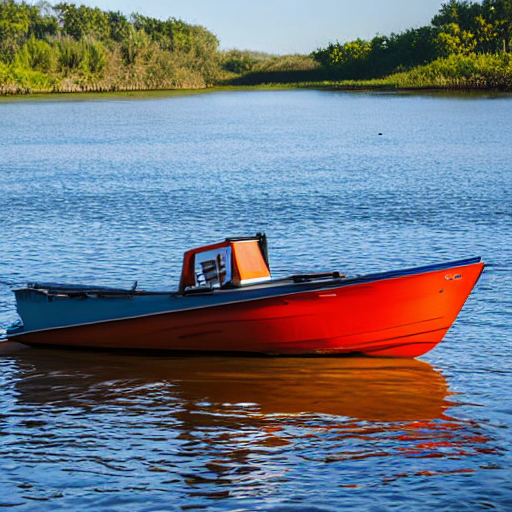

In [5]:
boat = agent.run("Generate an image of a boat in the water")
boat

==Explanation from the agent==
I will use the following  tools: `image_generator` to generate an image, then `image_transformer` to transform the image.


==Code generated by the agent==
image = image_generator(prompt="a man on mars riding a horse")
image = image_transformer(image=image, prompt="a man on mars riding a horse")


==Result==


A new version of the following files was downloaded from https://huggingface.co/space/huggingface-tools/image-transformation:
- image_transformation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


  0%|          | 0/25 [00:00<?, ?it/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

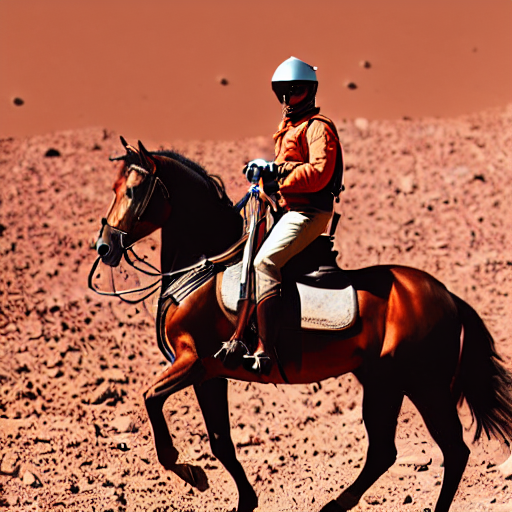

In [6]:
man_on_mars = agent.run("Generate an image of a man on mars riding a horse")
man_on_mars

In [7]:
!pip install "accelerate>=0.16.0,<1" "transformers[torch]>=4.28.1,<5" "torch>=1.13.1,<2"


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 991.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 37.4 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 1.13.1 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 1.

In [1]:
import torch
from transformers import pipeline

generate_text = pipeline(model="databricks/dolly-v2-3b", torch_dtype=torch.bfloat16, trust_remote_code=True, device_map="auto")


A new version of the following files was downloaded from https://huggingface.co/databricks/dolly-v2-3b:
- instruct_pipeline.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [2]:
res = generate_text("Explain to me the difference between nuclear fission and fusion.")
print(res[0]["generated_text"])


In a nuclear reactor, fissile atoms undergo a nuclear fission reaction, releasing free neutrons that another fissile atom can absorb to undergo a nuclear fusion reaction. In the fusion process, high pressure, temperatures and several fusion reactions occur in a very short period of time, resulting in the creation of electricity.
